## Files used in bertFuncs.py

In [1]:
from bert_functions_v2 import analyzeWord, getBert
from createDims import createPolarDimension
from get_data_from_file import create_lookup_from_data_file
import nltk
from nltk.corpus import wordnet as wn
import numpy as np
import pickle
import json
import string
import ast
import torch
import pandas as pd
import re

ModuleNotFoundError: No module named 'bertFuncs'

## Creating the required lookup files

The lookup files are needed to set up the POLAR dimensions and to match these dimensions to word sense definitions and example sentences, when analyzing the result.

The function ``create_lookup_files`` takes a list of lists as input. Each inner list contains a polar sense pair, where each word sense must be in WordNet readable format e.g. ``cold.a.01``), in orderder to automatically retrieve definitions and example sentences. All lookup files will be stored in the folder ``lookup_path``. 

In [10]:
out='antonyms_file/'
file='data_file.xlsx'

In [11]:
create_lookup_from_data_file(file,out)

In [2]:
# helper functions

def get_name(antonym):
    return wn.synset(antonym).lemma_names()[0]

#def get_examples(antonym):
#    examples = wn.synset(antonym).examples()
    # replace punctuation symbols with spaces
#    examples = [sent.translate(str.maketrans({k: " " for k in string.punctuation})) for sent in examples]
    # add a space after each sentence
#    return ['{} '.format(sent) for sent in examples]

In [3]:
def get_examples(antonym):
    antonym= wn.synset(antonym)
    examples=antonym.examples()
    #save only examples that containt the required word
    correct_examples=[]
    for example in examples:
        if re.search(r'\b'+str(antonym.lemma_names()[0])+'\\b', example, re.I) is not None:
            correct_examples.append(example)
    

    
    examples = [sent.translate(str.maketrans({k: " " for k in string.punctuation})) for sent in correct_examples]
    # add a space after each sentence
    return ['{} '.format(sent) for sent in examples]

In [14]:
wn.synset('sedate.v.01').examples()

['The patient must be sedated before the operation']

In [4]:
get_examples('clean.a.07')

['a clean fuel ', 'the tactical bomb is reasonably clean ']

In [5]:
def create_lookup_files(antonyms, lookup_path):
    if len(np.unique(antonyms, axis=0)) != len(antonyms):
        print("Your antonym list contains duplicates. Please try again!")
        return
    
    # get all word sense definitions
    synset_defs = [[wn.synset(anto).definition() for anto in pair] for pair in antonyms]
    # get example sentences from wordnet
    examples_readable = {str(pair):{get_name(anto): get_examples(anto) for anto in pair} for pair in antonyms}
    examples_lookup = [[[get_name(anto), get_examples(anto)] for anto in pair] for pair in antonyms]
    
    # save 
    with open(out_path + 'lookup_synset_dict.txt', 'w') as t:
        t.write(json.dumps(antonyms, indent=4))
    with open(out_path + 'lookup_synset_dict.pkl', 'wb') as p:
        pickle.dump(antonyms, p)
    with open(lookup_path + 'lookup_synset_definition.txt', 'w') as t:
        t.write(json.dumps(synset_defs, indent=4))  
    with open(lookup_path + 'lookup_synset_definition.pkl', 'wb') as p:
        pickle.dump(synset_defs, p)        
    with open(lookup_path + 'antonym_wordnet_example_sentences_readable_extended.txt', 'w') as t:
        t.write(json.dumps(examples_readable, indent=4))  
    with open(lookup_path + 'lookup_anto_example_dict.txt', 'w') as t:
        t.write(json.dumps(examples_lookup, indent=4))      
    with open(lookup_path + 'lookup_anto_example_dict.pkl', 'wb') as p:
        pickle.dump(examples_lookup, p)
    return


In [9]:
def create_dimensions_list():
    from collections import defaultdict
    word="1"
    #d for dimensions
    d=[]
    while word != '' :
        antonyms=defaultdict()
        index=0
        word=input('Enter word: ')
        if word !='':
            #get all synstets
            synsets=wn.synsets(word)

            #create dictionary only with synsets that have an antonym
            for i in synsets:
                if(len(i.lemmas()[0].antonyms()) !=0):
                    ant=i.lemmas()[0].antonyms()[0]
                    antonyms[i]=ant.synset()
                    
            #keep only antonym pairs that have examples
            for key in list(antonyms.keys()):
                if (len(key.examples())==0 or len(antonyms[key].examples())==0):
                    del antonyms[key]


            #visualize definitions

            for key in list(antonyms.keys()):
                print("Antonym pair index {}".format(index))
                print("   Antonym pair {}-----{} ".format(key,antonyms[key]))
                print("        Definition {} => {} ".format(key,key.definition()))
                print("        Definition {} => {} ".format(antonyms[key],antonyms[key].definition()))
                print(" ")
                print(" ")
                print(" ")
                index+=1
            
            #create list of desired dimensions 
            selected_antonym_pair_index=int(input('Enter the index of desired antonym pair: '))

            key=list(antonyms.keys())[selected_antonym_pair_index]

            d.append(list([key.name(),antonyms[key].name()]))
            print(" ")
            print(" ")
            print(" ")

    return d



In [10]:
def create_dims_with_adj_list():

    adjectives=pd.read_csv(r"C:\Users\VogliA\Desktop\adjective_list_eng.csv",header=None)
    adjectives=list(adjectives[0])
    adjectives
    from collections import defaultdict
    adj_ant_pairs=[]
    d=[]
    sorted_d=[]
    for word in adjectives:
        antonyms=defaultdict()

        synsets=wn.synsets(word)
         #create dictionary only with synsets that have an antonym
        for i in synsets:
            if(len(i.lemmas()[0].antonyms()) !=0):
                ant=i.lemmas()[0].antonyms()[0]
                antonyms[i]=ant.synset()
        #keep only antonym pairs that have examples
        for key in list(antonyms.keys()):
            if (len(key.examples())==0 or len(antonyms[key].examples())==0):
                del antonyms[key]
        if len(list(antonyms.keys())) !=0:
         #append the list of dimmensions
            for key in list(antonyms.keys()):
                d.append(sorted(list([key.name(),antonyms[key].name()])))

    #remove duplicates
    df=pd.DataFrame(d)
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)        
    dims=[]
    for index, value in enumerate(df[0]):
        dims.append(list([value,df[1][index]]))

    return dims


## Example usage

Polar dimensions should be __given__ as nested list of antonym pairs in wordnet representation (sense-annotated).

_Example:_   
`
[
    ['a_posteriori.a.01', 'a_priori.a.01'],
    ['abaxial.a.01', 'adaxial.a.01'],
    ['abridge.v.01', 'elaborate.v.01'],
    ...
]`

In [6]:
# folder in which all lookup files will be stored
out_path = 'antonyms/'

In [22]:
#dims=create_dimensions_list()
dims=create_dims_with_adj_list()

dims

[['nasty.a.01', 'nice.a.01'],
 ['better.v.02', 'worsen.v.02'],
 ['better.v.03', 'worsen.v.01'],
 ['better.a.01', 'worse.a.01'],
 ['better.a.02', 'worse.a.02'],
 ['bad.a.01', 'good.a.01'],
 ['ill.a.01', 'well.a.01'],
 ['ill.r.01', 'well.r.01'],
 ['ill.r.02', 'well.r.06'],
 ['badly.r.07', 'well.r.10'],
 ['badly.r.08', 'well.r.11'],
 ['badly.r.10', 'well.r.13'],
 ['bloodless.a.02', 'bloody.a.01'],
 ['brave.n.02', 'timid.n.01'],
 ['brave.a.01', 'cowardly.a.01'],
 ['busy.a.01', 'idle.a.01'],
 ['cautious.a.01', 'incautious.a.01'],
 ['clean.v.01', 'dirty.v.01'],
 ['clean.a.01', 'dirty.a.01'],
 ['clean.a.07', 'dirty.a.04'],
 ['clean.a.08', 'dirty.a.02'],
 ['fairly.r.03', 'unfairly.r.01'],
 ['clear.a.11', 'cloudy.a.02'],
 ['crowded.a.01', 'uncrowded.a.01'],
 ['dead.n.01', 'living.n.02'],
 ['alive.a.01', 'dead.a.01'],
 ['dead.a.02', 'live.a.02'],
 ['different.a.01', 'same.a.02'],
 ['like.a.01', 'unlike.a.01'],
 ['distinct.a.02', 'indistinct.a.01'],
 ['eager.a.01', 'uneager.a.01'],
 ['discouragin

In [23]:
len(dims)

163

In [15]:
dims=create_dimensions_list()

Enter word: interested
Antonym pair index 0
   Antonym pair Synset('interested.a.01')-----Synset('uninterested.a.01') 
        Definition Synset('interested.a.01') => having or showing interest; especially curiosity or fascination or concern 
        Definition Synset('uninterested.a.01') => not having or showing interest 
 
 
 
Enter the index of desired antonym pair: 0
 
 
 
Enter word: 


In [16]:
dims

[['interested.a.01', 'uninterested.a.01']]

In [17]:
create_lookup_files(dims, out_path)

In [33]:
# define 3 exemplary POLAR dimensions
#dims = [['cold.a.01', 'hot.a.01'], ['bad.a.01', 'good.a.01'], ['intelligent.a.01', 'unintelligent.a.01'], ['capable.a.01', 'incapable.a.01'],['better.a.02', 'worse.a.02'],['open.a.01', 'shut.a.01'],  ['interested.a.01', 'uninterested.a.01'],['foreign.a.02', 'native.a.01']]
#dims=[['nasty.a.01', 'nice.a.01'], ['bad.a.01', 'good.a.01'], ['ill.a.01', 'well.a.01'], ['ill.r.01', 'well.r.01'],['ill.r.02', 'well.r.06'],['badly.r.07', 'well.r.10']]   
# create all lookup files
#create_lookup_files(dims, out_path)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [55]:
dims=[['nasty.a.01', 'nice.a.01'],
 ['better.a.01', 'worse.a.01'],
 ['better.a.02', 'worse.a.02'],
 ['bad.a.01', 'good.a.01'],
 ['ill.a.01', 'well.a.01'],
 ['ill.r.01', 'well.r.01'],
 ['ill.r.02', 'well.r.06'],
 ['badly.r.07', 'well.r.10'],
 ['badly.r.08', 'well.r.11'],
 ['badly.r.10', 'well.r.13'],
 ['bloodless.a.02', 'bloody.a.01'],
 ['brave.n.02', 'timid.n.01'],
 ['brave.a.01', 'cowardly.a.01'],
 ['busy.a.01', 'idle.a.01'],
 ['cautious.a.01', 'incautious.a.01'],
 ['clean.a.01', 'dirty.a.01'],
 ['clean.a.07', 'dirty.a.04'],
 ['clean.a.08', 'dirty.a.02'],
 ['fairly.r.03', 'unfairly.r.01'],
 ['clear.a.11', 'cloudy.a.02'],
 ['crowded.a.01', 'uncrowded.a.01'],
 ['dead.n.01', 'living.n.02'],
 ['alive.a.01', 'dead.a.01'],
 ['dead.a.02', 'live.a.02'],
 ['different.a.01', 'same.a.02'],
 ['like.a.01', 'unlike.a.01'],
 ['distinct.a.02', 'indistinct.a.01'],
 ['eager.a.01', 'uneager.a.01'],
 ['discouraging.a.01', 'encouraging.a.01'],
 ['cheap.a.01', 'expensive.a.01'],
 ['faithful.a.01', 'unfaithful.a.01'],
 ['faithful.a.03', 'unfaithful.a.02'],
 ['coarse.a.01', 'fine.a.05'],
 ['frail.a.01', 'robust.a.01'],
 ['glorious.a.01', 'inglorious.a.02'],
 ['healthy.a.01', 'unhealthy.a.01'],
 ['reasonably.r.01', 'unreasonably.r.02'],
 ['lucky.a.02', 'unlucky.a.01'],
 ['imperfect.a.01', 'perfect.a.01'],
 ['real.a.01', 'unreal.a.01'],
 ['real.a.02', 'unreal.a.02'],
 ['nominal.a.04', 'real.a.06'],
 ['insubstantial.a.01', 'substantial.a.03'],
 ['poor.a.02', 'rich.a.01'],
 ['poor.a.04', 'rich.a.02'],
 ['lean.a.02', 'rich.a.07'],
 ['poor.a.03', 'rich.a.08'],
 ['glazed.a.03', 'unglazed.a.02'],
 ['intelligent.a.01', 'unintelligent.a.01'],
 ['tender.a.01', 'tough.a.01'],
 ['tender.a.06', 'tough.a.03'],
 ['grateful.a.01', 'ungrateful.a.01'],
 ['rested.a.01', 'tired.a.01'],
 ['beautiful.a.01', 'ugly.a.01'],
 ['right.n.07', 'wrong.n.01'],
 ['correct.a.01', 'incorrect.a.01'],
 ['right.a.04', 'wrong.a.02'],
 ['right.a.05', 'wrong.a.05'],
 ['correctly.r.01', 'incorrectly.r.02'],
 ['attractive.a.01', 'unattractive.a.01'],
 ['attractive.a.03', 'repulsive.a.02'],
 ['bad.n.01', 'good.n.03'],
 ['regretful.a.01', 'unregretful.a.01'],
 ['breakable.a.01', 'unbreakable.a.01'],
 ['calm.a.02', 'stormy.a.01'],
 ['clear.a.01', 'unclear.a.02'],
 ['clear.a.04', 'opaque.a.01'],

 ['comfortable.a.01', 'uncomfortable.a.02'],
 ['comfortable.a.02', 'uncomfortable.a.01'],
 ['dangerous.a.01', 'safe.a.01'],
 ['defeated.a.01', 'undefeated.a.01'],
 ['difficult.a.01', 'easy.a.01'],

 ['quickly.r.01', 'slowly.r.01'],
 ['energetic.a.01', 'lethargic.a.01'],
 ['evil.n.03', 'good.n.02'],
 ['foolish.a.01', 'wise.a.01'],
 ['hungry.a.01', 'thirsty.a.02'],
 ['important.a.01', 'unimportant.a.01'],
 ['guilty.a.01', 'innocent.a.01'],
 ['joyless.a.01', 'joyous.a.01'],
 ['heavy.a.01', 'light.a.01'],
 ['dark.a.02', 'light.a.02'],
 ['heavy.a.03', 'light.a.03'],
 ['heavy.a.02', 'light.a.04'],
 ['heavy.a.04', 'light.a.05'],
 ['dark.a.01', 'light.a.06'],
 ['heavy.a.08', 'light.a.13'],
 ['heavy.a.09', 'light.a.14'],
 ['long.a.01', 'short.a.01'],
 ['long.a.02', 'short.a.02'],
 ['long.a.05', 'short.a.06'],

 ['disobedient.a.01', 'obedient.a.01'],
 ['fancy.a.01', 'plain.a.02'],
 ['confident.a.01', 'diffident.a.02'],
 ['sparkling.a.02', 'still.a.05'],
 ['tame.a.02', 'wild.a.01'],
 ['tame.a.03', 'wild.a.02'],
 ['lax.a.03', 'tense.a.03'],
 ['thoughtful.a.02', 'thoughtless.a.01'],
 ['heedful.a.01', 'heedless.a.01'],
 ['unusual.a.01', 'usual.a.01'],
 ['familiar.a.02', 'strange.a.01'],
 ['black.a.01', 'white.a.01'],
 ['black.a.02', 'white.a.02'],
 ['bright.a.01', 'dull.a.02'],
 ['dimmed.a.01', 'undimmed.a.01'],
 ['careful.a.01', 'careless.a.01'],
 ['cheerful.a.01', 'depressing.a.01'],
 ['colorful.a.02', 'colorless.a.01'],
 ['colored.a.01', 'uncolored.a.01'],
 ['concerned.a.01', 'unconcerned.a.01'],
 ['cooperative.a.02', 'uncooperative.a.01'],
 ['curious.a.02', 'incurious.a.01'],
 ['compliant.a.01', 'defiant.a.01'],
 ['dull.a.01', 'lively.a.01'],
 ['dull.a.06', 'sharp.a.08'],
 ['dull.a.09', 'sharp.a.09'],
 ['dejected.a.01', 'elated.a.01'],
 ['enthusiastic.a.01', 'unenthusiastic.a.01'],
 ['fair.a.01', 'unfair.a.01'],
 ['friendly.a.01', 'unfriendly.a.02'],
 ['friendly.a.03', 'unfriendly.a.01'],
 ['friendly.a.04', 'hostile.a.02'],
 ['happy.a.01', 'unhappy.a.01'],
 ['impossible.a.01', 'possible.a.01'],
 ['kind.a.01', 'unkind.a.01'],
 ['open.a.01', 'shut.a.01'],
 ['closed.a.01', 'open.a.02'],
 ['closed.a.04', 'open.a.05'],
 ['covert.a.01', 'overt.a.01'],
 ['pleasant.a.01', 'unpleasant.a.01'],
 ['humble.a.02', 'proud.a.01'],
 ['foreign.a.02', 'native.a.01'],
 ['troubled.a.01', 'untroubled.a.01'],
 ['interested.a.01', 'uninterested.a.01']]

In [56]:
create_lookup_files(dims, out_path)

In [57]:
len(dims)

135

In [54]:
wn.synset('open.a.05').examples()

['keep your eyes open', 'his mouth slightly opened']

In [28]:
dims

[['nasty.a.01', 'nice.a.01'],
 ['better.a.01', 'worse.a.01'],
 ['better.a.02', 'worse.a.02'],
 ['bad.a.01', 'good.a.01'],
 ['ill.a.01', 'well.a.01'],
 ['ill.r.01', 'well.r.01'],
 ['ill.r.02', 'well.r.06'],
 ['badly.r.07', 'well.r.10'],
 ['badly.r.08', 'well.r.11'],
 ['badly.r.10', 'well.r.13'],
 ['bloodless.a.02', 'bloody.a.01'],
 ['brave.n.02', 'timid.n.01'],
 ['brave.a.01', 'cowardly.a.01'],
 ['busy.a.01', 'idle.a.01'],
 ['cautious.a.01', 'incautious.a.01'],
 ['clean.a.01', 'dirty.a.01'],
 ['clean.a.07', 'dirty.a.04'],
 ['clean.a.08', 'dirty.a.02'],
 ['fairly.r.03', 'unfairly.r.01'],
 ['clear.a.11', 'cloudy.a.02'],
 ['crowded.a.01', 'uncrowded.a.01'],
 ['dead.n.01', 'living.n.02'],
 ['alive.a.01', 'dead.a.01'],
 ['dead.a.02', 'live.a.02'],
 ['different.a.01', 'same.a.02'],
 ['like.a.01', 'unlike.a.01'],
 ['distinct.a.02', 'indistinct.a.01'],
 ['eager.a.01', 'uneager.a.01'],
 ['discouraging.a.01', 'encouraging.a.01'],
 ['cheap.a.01', 'expensive.a.01'],
 ['faithful.a.01', 'unfaithful.a

In [10]:

wn.synset('ill.r.01').examples()

['he was ill prepared',
 'it ill befits a man to betray old friends',
 'the car runs badly',
 'he performed badly on the exam',
 'the team played poorly',
 'ill-fitting clothes',
 'an ill-conceived plan']

In [12]:
# get the embedding model 
tokenizer, model = getBert()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Create the POLAR matrix (for base change or projection) from a given set of antonyms. The antonyms and their example sentences are forwarded to an embedding model (here: BERT) from which the required embeddings and difference vectors are created. ``antonym_path`` specifies where the readable example sentence lookup file is currently stored. ``out_path`` specifies where the POLAR matrix should be stored.

The corresponding function can be found in ``createDims.py`` which is not part of the official SensePOLAR repo.

In [13]:
# create the base change matrix (this might take some time)
createPolarDimension(model, tokenizer, out_path=out, antonym_path=out + "antonym_wordnet_example_sentences_readable_extended.txt")

Start forwarding the Polar opposites ...


In [6]:
len(dims)

NameError: name 'dims' is not defined

In [16]:
# base change does not work well with only few dimensions -> compare with projection
antonym_path = out + "polar_dimensions.pkl"
word = "school"
context = "school teaches you a lot of good and smart things"
analyzeWord(word, context, model=model,tokenizer=tokenizer, antonym_path=antonym_path, lookup_path=out, numberPolar=2,method="projection") #method="projection"

Analyzing the word:  school
In the context of:  school teaches you a lot of good and smart things
Top:  1
Dimension:  test<------>test2
Definitions:  definition test1<------>definition test2
Value: -2.6646461


Top:  2
Dimension:  one<------>two
Definitions:  definition one<------>definition two
Value:                      1.0413853




(['test---test2', 'one---two'],
 array([-2.6646461,  1.0413853], dtype=float32),
 {('test', 'test2'): -2.6646461, ('one', 'two'): 1.0413853},
 'school')

In [44]:
antonym_path = out_path + "polar_dimensions.pkl"
word = "fire"
context = "the fire has generated extreme temperature"

analyzeWord(word, context, model=model, tokenizer=tokenizer, antonym_path=antonym_path, lookup_path=out_path, numberPolar=len(dims), method="projection")

Analyzing the word:  fire
In the context of:  the fire has generated extreme temperature
Top:  1
Dimension:  foreign<------>native
Definitions:  relating to or originating in or characteristic of another place or part of the world<------>characteristic of or existing by virtue of geographic origin
Value:                      2.3423314


Top:  2
Dimension:  cold<------>hot
Definitions:  having a low or inadequate temperature or feeling a sensation of coldness or having been made cold by e.g. ice or refrigeration<------>used of physical heat; having a high or higher than desirable temperature or giving off heat or feeling or causing a sensation of heat or burning
Value:                      1.9840217


Top:  3
Dimension:  interested<------>uninterested
Definitions:  having or showing interest; especially curiosity or fascination or concern<------>not having or showing interest
Value: -1.0291702


Top:  4
Dimension:  bad<------>good
Definitions:  having undesirable or negative qualities<-

(['foreign---native',
  'cold---hot',
  'interested---uninterested',
  'bad---good',
  'intelligent---unintelligent',
  'better---worse',
  'capable---incapable',
  'open---shut'],
 array([ 1.9840217 , -0.9941054 , -0.60276836,  0.31034747,  0.34254825,
        -0.2289842 , -1.0291702 ,  2.3423314 ], dtype=float32),
 {('foreign', 'native'): 2.3423314,
  ('cold', 'hot'): 1.9840217,
  ('interested', 'uninterested'): -1.0291702,
  ('bad', 'good'): -0.9941054,
  ('intelligent', 'unintelligent'): -0.60276836,
  ('better', 'worse'): 0.34254825,
  ('capable', 'incapable'): 0.31034747,
  ('open', 'shut'): -0.2289842},
 'fire')

In [45]:
Y=analyzeWord(word, context, model=model, tokenizer=tokenizer, antonym_path=antonym_path, lookup_path=out_path, numberPolar=len(dims), method="projection")

Analyzing the word:  fire
In the context of:  the fire has generated extreme temperature
Top:  1
Dimension:  foreign<------>native
Definitions:  relating to or originating in or characteristic of another place or part of the world<------>characteristic of or existing by virtue of geographic origin
Value:                      2.3423314


Top:  2
Dimension:  cold<------>hot
Definitions:  having a low or inadequate temperature or feeling a sensation of coldness or having been made cold by e.g. ice or refrigeration<------>used of physical heat; having a high or higher than desirable temperature or giving off heat or feeling or causing a sensation of heat or burning
Value:                      1.9840217


Top:  3
Dimension:  interested<------>uninterested
Definitions:  having or showing interest; especially curiosity or fascination or concern<------>not having or showing interest
Value: -1.0291702


Top:  4
Dimension:  bad<------>good
Definitions:  having undesirable or negative qualities<-

In [11]:
Y

(['cold---hot',
  'intelligent---unintelligent',
  'capable---incapable',
  'bad---good'],
 array([ 3.166437  , -0.16076842, -1.3334521 ,  0.23145995], dtype=float32),
 {('cold', 'hot'): 3.166437,
  ('intelligent', 'unintelligent'): -1.3334521,
  ('capable', 'incapable'): 0.23145995,
  ('bad', 'good'): -0.16076842},
 'fire')

In [46]:
dimensions=Y[0]
values=Y[1]
dim_values=Y[2]


In [47]:
dimensions


['foreign---native',
 'cold---hot',
 'interested---uninterested',
 'bad---good',
 'intelligent---unintelligent',
 'better---worse',
 'capable---incapable',
 'open---shut']

In [48]:
values

array([ 1.9840217 , -0.9941054 , -0.60276836,  0.31034747,  0.34254825,
       -0.2289842 , -1.0291702 ,  2.3423314 ], dtype=float32)

In [49]:
dim_values

{('foreign', 'native'): 2.3423314,
 ('cold', 'hot'): 1.9840217,
 ('interested', 'uninterested'): -1.0291702,
 ('bad', 'good'): -0.9941054,
 ('intelligent', 'unintelligent'): -0.60276836,
 ('better', 'worse'): 0.34254825,
 ('capable', 'incapable'): 0.31034747,
 ('open', 'shut'): -0.2289842}

In [50]:
def visual_representation_one_word(dim_values):

    import matplotlib.pyplot as plt
    import numpy as np

    left_axis=[]
    for i in dim_values.keys():
        left_axis.append(i[0])

    right_axis=[]
    for i in dim_values.keys():
        right_axis.append(i[1])

    val=list(dim_values.values())

    np.random.seed(19680801)

    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    ticks_frequency = 1
    y_pos = np.arange(len(right_axis))
    ax.set(xlim=(-6, 6))
    ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)
  
    ax.barh(y_pos, val, align='center')
    ax.set_yticks(y_pos, labels=left_axis)
    ax.invert_yaxis()  # labels read top-to-bottom


    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(y_pos,right_axis)


    
    return plt.show()

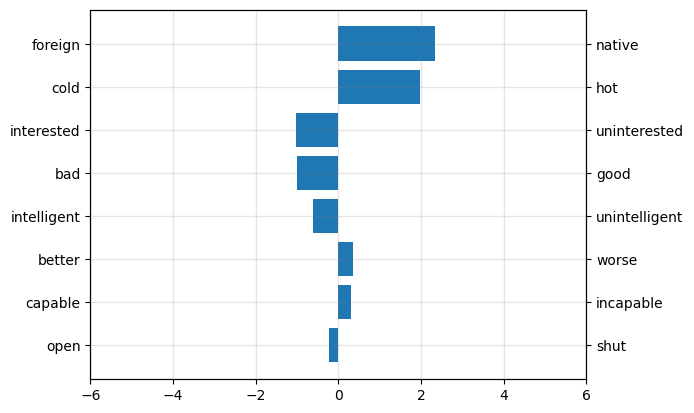

In [51]:
visual_representation_one_word(dim_values)

In [18]:
antonym_path = out_path + "polar_dimensions.pkl"
word = "bank"
context = "he received a loan from the bank"

analyzeWord(word, context, model=model, tokenizer=tokenizer, antonym_path=antonym_path, lookup_path=out_path, numberPolar=4, method="projection")

Analyzing the word:  bank
In the context of:  he received a loan from the bank
Top:  1
Dimension:  cold<------>hot
Definitions:  having a low or inadequate temperature or feeling a sensation of coldness or having been made cold by e.g. ice or refrigeration<------>used of physical heat; having a high or higher than desirable temperature or giving off heat or feeling or causing a sensation of heat or burning
Value: -2.7727177


Top:  2
Dimension:  bad<------>good
Definitions:  having undesirable or negative qualities<------>having desirable or positive qualities especially those suitable for a thing specified
Value: -2.1117988


Top:  3
Dimension:  intelligent<------>unintelligent
Definitions:  having the capacity for thought and reason especially to a high degree<------>lacking intelligence
Value: -0.79782534


Top:  4
Dimension:  capable<------>incapable
Definitions:  (usually followed by `of') having capacity or ability<------>(followed by `of') lacking capacity or ability
Value: -0.5

(['cold---hot',
  'bad---good',
  'intelligent---unintelligent',
  'capable---incapable'],
 array([-2.7727177 , -2.1117988 , -0.79782534, -0.59912497], dtype=float32),
 {('cold', 'hot'): -2.7727177,
  ('bad', 'good'): -2.1117988,
  ('intelligent', 'unintelligent'): -0.79782534,
  ('capable', 'incapable'): -0.59912497},
 'bank')

In [19]:
Y=analyzeWord(word, context, model=model, tokenizer=tokenizer, antonym_path=antonym_path, lookup_path=out_path, numberPolar=4, method="projection")

Analyzing the word:  bank
In the context of:  he received a loan from the bank
Top:  1
Dimension:  cold<------>hot
Definitions:  having a low or inadequate temperature or feeling a sensation of coldness or having been made cold by e.g. ice or refrigeration<------>used of physical heat; having a high or higher than desirable temperature or giving off heat or feeling or causing a sensation of heat or burning
Value: -2.7727177


Top:  2
Dimension:  bad<------>good
Definitions:  having undesirable or negative qualities<------>having desirable or positive qualities especially those suitable for a thing specified
Value: -2.1117988


Top:  3
Dimension:  intelligent<------>unintelligent
Definitions:  having the capacity for thought and reason especially to a high degree<------>lacking intelligence
Value: -0.79782534


Top:  4
Dimension:  capable<------>incapable
Definitions:  (usually followed by `of') having capacity or ability<------>(followed by `of') lacking capacity or ability
Value: -0.5

In [20]:
dim_values=Y[2]

In [21]:
dim_values

{('cold', 'hot'): -2.7727177,
 ('bad', 'good'): -2.1117988,
 ('intelligent', 'unintelligent'): -0.79782534,
 ('capable', 'incapable'): -0.59912497}

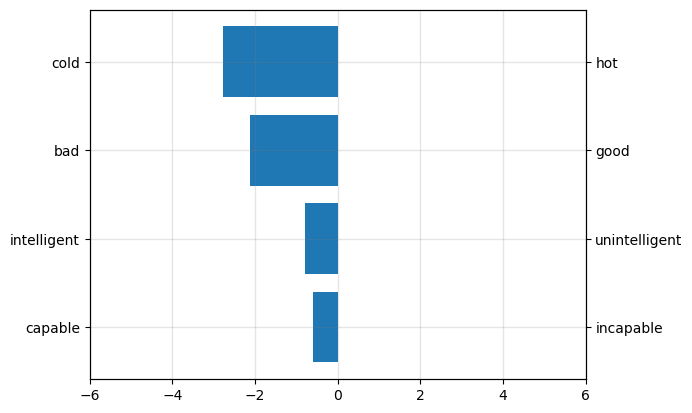

In [22]:
visual_representation_one_word(dim_values)

In [23]:
coordinates=list(dim_values.values())
coordinatesX=coordinates[0]
coordinatesY=coordinates[1]

In [24]:
coordinatesX

-2.7727177

In [25]:
coordinatesY

-2.1117988

In [26]:
antonym_path = out_path + "polar_dimensions.pkl"
word = "world"
context = "world is a planet in solar system"

Z=analyzeWord(word, context, model=model, tokenizer=tokenizer, antonym_path=antonym_path, lookup_path=out_path, numberPolar=4, method="projection")

Analyzing the word:  world
In the context of:  world is a planet in solar system
Top:  1
Dimension:  intelligent<------>unintelligent
Definitions:  having the capacity for thought and reason especially to a high degree<------>lacking intelligence
Value: -2.279831


Top:  2
Dimension:  cold<------>hot
Definitions:  having a low or inadequate temperature or feeling a sensation of coldness or having been made cold by e.g. ice or refrigeration<------>used of physical heat; having a high or higher than desirable temperature or giving off heat or feeling or causing a sensation of heat or burning
Value: -1.4764019


Top:  3
Dimension:  bad<------>good
Definitions:  having undesirable or negative qualities<------>having desirable or positive qualities especially those suitable for a thing specified
Value: -1.2049234


Top:  4
Dimension:  capable<------>incapable
Definitions:  (usually followed by `of') having capacity or ability<------>(followed by `of') lacking capacity or ability
Value:     

In [27]:
antonym_path = out_path + "polar_dimensions.pkl"
word = "bank"
context = "he received a loan from the bank"

X=analyzeWord(word, context, model=model, tokenizer=tokenizer, antonym_path=antonym_path, lookup_path=out_path, numberPolar=4, method="projection")

Analyzing the word:  bank
In the context of:  he received a loan from the bank
Top:  1
Dimension:  cold<------>hot
Definitions:  having a low or inadequate temperature or feeling a sensation of coldness or having been made cold by e.g. ice or refrigeration<------>used of physical heat; having a high or higher than desirable temperature or giving off heat or feeling or causing a sensation of heat or burning
Value: -2.7727177


Top:  2
Dimension:  bad<------>good
Definitions:  having undesirable or negative qualities<------>having desirable or positive qualities especially those suitable for a thing specified
Value: -2.1117988


Top:  3
Dimension:  intelligent<------>unintelligent
Definitions:  having the capacity for thought and reason especially to a high degree<------>lacking intelligence
Value: -0.79782534


Top:  4
Dimension:  capable<------>incapable
Definitions:  (usually followed by `of') having capacity or ability<------>(followed by `of') lacking capacity or ability
Value: -0.5

In [28]:
antonym_path = out_path + "polar_dimensions.pkl"
word = "hospital"
context = "he was visiting his aunt in hospital"

Y=analyzeWord(word, context, model=model, tokenizer=tokenizer, antonym_path=antonym_path, lookup_path=out_path, numberPolar=4, method="projection")

Analyzing the word:  hospital
In the context of:  he was visiting his aunt in hospital
Top:  1
Dimension:  bad<------>good
Definitions:  having undesirable or negative qualities<------>having desirable or positive qualities especially those suitable for a thing specified
Value: -3.547968


Top:  2
Dimension:  cold<------>hot
Definitions:  having a low or inadequate temperature or feeling a sensation of coldness or having been made cold by e.g. ice or refrigeration<------>used of physical heat; having a high or higher than desirable temperature or giving off heat or feeling or causing a sensation of heat or burning
Value: -1.1850531


Top:  3
Dimension:  capable<------>incapable
Definitions:  (usually followed by `of') having capacity or ability<------>(followed by `of') lacking capacity or ability
Value:                      0.9438236


Top:  4
Dimension:  intelligent<------>unintelligent
Definitions:  having the capacity for thought and reason especially to a high degree<------>lackin

In [35]:
def two_dim_visualization(results_of_analyse_word): #the variable should be a list
    #Retreive the antonyms list
    keys=list(results_of_analyse_word[0][2].keys())
    
    #ask from user for the keys
    key_input_1=input('Enter the first antonym pair number')
    key_input_2=input('Enter the second antonym pair number')
    #select two antonym pairs
    keyx=keys[int(key_input_1)]
    keyy=keys[int(key_input_2)]
    
    #list to store values
    valuesx=[]
    valuesy=[]
    
    words=[]
    for results in results_of_analyse_word:
        words.append(results[3])
        dim=results[2]
        valuesx.append(dim[keyx])
        valuesy.append(dim[keyy])

        
    import numpy as np
    import matplotlib.pyplot as plt    

    # Enter x and y coordinates of points and colors
    xs = valuesx
    ys = valuesy
    
    #list of colors  !!!!limits the length of input, should be equal or less than the list below
    colors_full = ['black', 'forestgreen','aqua','yellow','red','brown','magneta','goldenrod']
    
    colors=[]
    for i in range(len(valuesx)):
        colors.append(colors_full[i])
    # Select length of axes and the space between tick labels
    xmin, xmax, ymin, ymax = -5, 5, -5, 5
    ticks_frequency = 1

    # Plot points
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(xs, ys, c=colors)

    # Draw lines connecting points to axes
    #for x, y, c in zip(xs, ys, colors):
    #    ax.plot([x, x], [0, y], c=c, ls='--', lw=1.5, alpha=0.5)
    #    ax.plot([0, x], [y, y], c=c, ls='--', lw=1.5, alpha=0.5)

    # Set identical scales for both axes
    ax.set(xlim=(xmin-1, xmax+1), ylim=(ymin-1, ymax+1), aspect='equal')

    # Set bottom and left spines as x and y axes of coordinate system
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Create 'x' and 'y' labels placed at the end of the axes
    ax.set_xlabel(keyx, size=14, labelpad=-21, x=1.03)
    ax.set_ylabel(keyy, size=14, labelpad=-15, y=1.02, rotation=0)



    # Create custom major ticks to determine position of tick labels
    x_ticks = np.arange(xmin, xmax+1, ticks_frequency)
    y_ticks = np.arange(ymin, ymax+1, ticks_frequency)
    ax.set_xticks(x_ticks[x_ticks != 0])
    ax.set_yticks(y_ticks[y_ticks != 0])

    # Create minor ticks placed at each integer to enable drawing of minor grid
    # lines: note that this has no effect in this example with ticks_frequency=1
    ax.set_xticks(np.arange(xmin, xmax+1), minor=True)
    ax.set_yticks(np.arange(ymin, ymax+1), minor=True)

    # Draw major and minor grid lines
    ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

    # Draw arrows
    arrow_fmt = dict(markersize=4, color='black', clip_on=False)
    ax.plot((1), (0), marker='>', transform=ax.get_yaxis_transform(), **arrow_fmt)
    ax.plot((0), (1), marker='^', transform=ax.get_xaxis_transform(), **arrow_fmt)
    
       
        
    return plt.show()
        
        
        
        
    

Enter the first antonym pair number2
Enter the second antonym pair number0


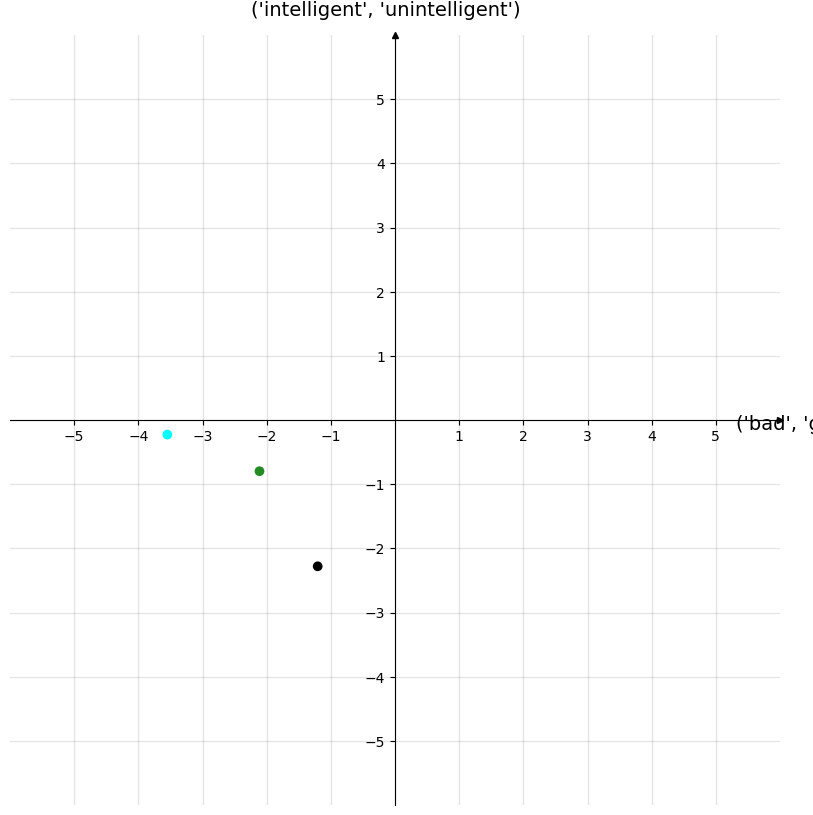

In [36]:
two_dim_visualization([Z,X,Y])

In [31]:
Y[3]

'hospital'

In [32]:
#visualizationn of antonyms with the highest difference

def most_descriptive_antonyms(word1,word2,k):


    from collections import defaultdict
    import matplotlib.pyplot as plt
    import numpy as np
    diff_dict=defaultdict()

    word1_dict=word1[2]
    word2_dict=word2[2]



    def intersection(lst1, lst2):
        lst3 = [value for value in lst1 if value in lst2]
        return lst3

    keys_word_1=list(word1_dict.keys())
    keys_word_2=list(word2_dict.keys())

    common_keys=intersection(keys_word_1,keys_word_2)


    difference_dict=defaultdict()

    for key in common_keys:
        difference_dict[key]=word1_dict[key]-word2_dict[key]

    sorted_difference_dict=dict(sorted(difference_dict.items(), key=lambda x:abs(x[1]) ,reverse=True))

    sorted_keys=list(sorted_difference_dict.keys())

    left_axis=[]
    right_axis=[]
    values_word1=[]
    values_word2=[]

    for i in range(k):
        left_axis.append(sorted_keys[i][0])
        right_axis.append(sorted_keys[i][1])
        values_word1.append(word1_dict[sorted_keys[i]])
        values_word2.append(word2_dict[sorted_keys[i]])



    plt.rcdefaults()
    fig, ax = plt.subplots()

    ax.set(xlim=(-5, 5))
    y_pos = np.arange(len(right_axis))
    width = 0.4

    ax.barh(y_pos, values_word1, width,align='center',label=word1[3])
    ax.barh(y_pos+width, values_word2, width,align='center',label=word2[3])
    ax.set_yticks(y_pos, labels=left_axis)
    ax.invert_yaxis()  # labels read top-to-bottom


    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(y_pos,right_axis)
    ax.legend()
    
    plt.show()

    return



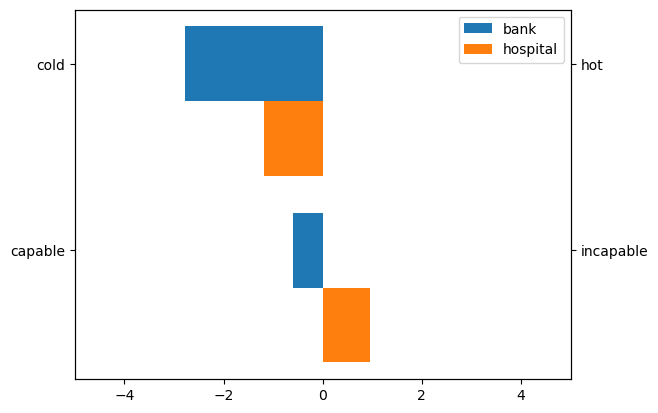

In [37]:
most_descriptive_antonyms(X,Y,2)

In [34]:
#def one_word_one_dimension(X):
